In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Congressional Voting Data

After you've downloaded the data from the repository, go ahead and load it with Pandas

In [19]:
votes = pd.read_csv('./assets/datasets/votes.csv')

For simplicity, drop rows with any missing values.

In [20]:
votes.dropna(inplace=True)

Encode the yes votes as 1, and no votes as 0

In [21]:
def converter(x):
    if x =="n":
        return 0
    elif x=="y":
        return 1
    else:
        return x

In [22]:
votes = votes.applymap(converter)

Create X and y (votes and party)

In [23]:
x = votes.ix[:,2:14].values
y = votes.ix[:,1].values

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [24]:
votes.head()

,Unnamed: 0,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
5,6,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,9,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,20,democrat,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,24,democrat,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,26,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


Standardize the data

In [25]:
xStand = StandardScaler().fit_transform(x)

/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Next, use sklearn to create a matrix of the data in the first 10 principal components

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
x_pca = pca.fit_transform(xStand)

Now, calculate the explained variance.

In [27]:
pca.explained_variance_ratio_

array([ 0.49671773,  0.11164966,  0.08346459,  0.06980698,  0.05846976,
        0.0453475 ,  0.03886442,  0.02742881,  0.02524226,  0.01845091])

In [28]:
pca_df = pd.DataFrame(x_pca).iloc[:,:3]

Use k nearest neighbors to predict party affiliation.  

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(pca_df.values,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, pca_df.values,y)

array([ 0.91025641,  0.90909091,  0.88311688])

In [12]:
from sklearn.cluster import KMeans

**Bonus**: Use Kmeans to cluster the data on the first three PCs.  Select two clusters (since there are two parties)

In [13]:
km = KMeans(n_clusters=2)
km.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Using pivot_table (or similar), show a confusion matrix of your k means labels and the true party labels

In [14]:
pca_df['party'] = list(votes.loc[:,'Class'])
pca_df['label'] = km.labels_
pca_df.columns = ['pc1', 'pc2', 'pc3', 'party', 'label']

In [15]:
pca_df.head()

,pc1,pc2,pc3,party,label
0,-0.988236,1.314296,0.566642,democrat,1
1,-3.043082,0.735341,1.044238,republican,1
2,3.097899,1.930205,0.567097,democrat,0
3,2.902566,0.831997,1.727415,democrat,0
4,3.073527,-1.322282,0.166521,democrat,0


In [16]:
pd.pivot_table(pca_df, index='party', columns = 'label', values='pc1', aggfunc=len)

label,0,1
party,,
democrat,106.0,18.0
republican,8.0,100.0


**Bonus**: create a 3D plot of the principal components.  Colour the points by label.

**Extra bonus:** add labels to show the actual party affiliation for each point

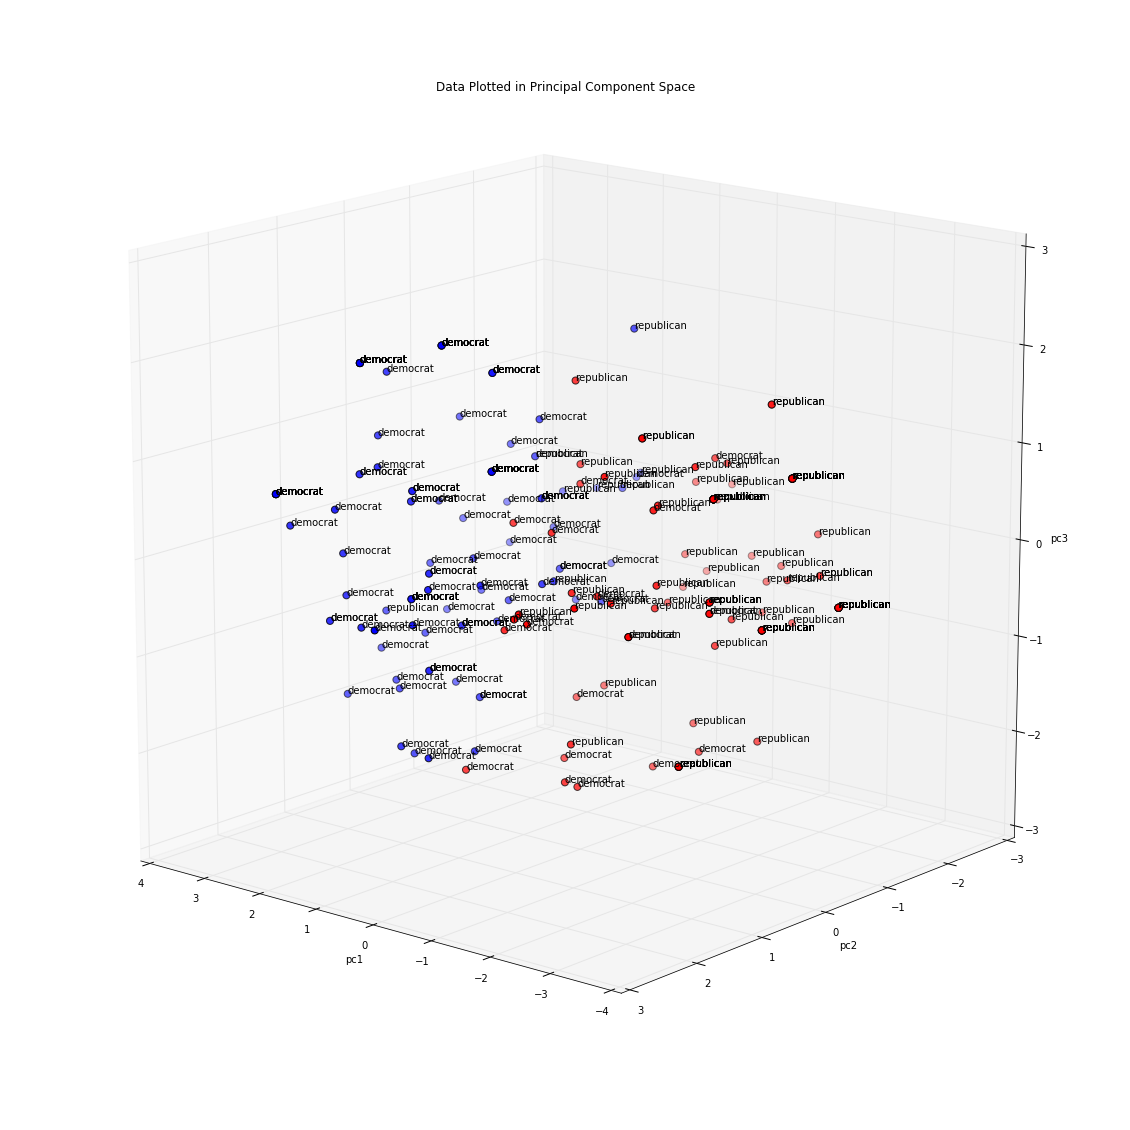

In [18]:
# plot data in pc space
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
cols = ['blue', 'red']

for i, col in zip(range(2), cols):

    sub = pca_df[pca_df['label']==i]
    ax.scatter(sub["pc1"],sub["pc2"],sub["pc3"], s=50, c=col)
    
for i, party in enumerate(pca_df['party']):

    ax.text(pca_df.iloc[i].pc1, pca_df.iloc[i].pc2, pca_df.iloc[i].pc3,party)
ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Data Plotted in Principal Component Space")
ax.view_init(15, 130)
plt.draw()

From this, we can see which democrats tend to vote like republicans, and vice versa.